<a href="https://colab.research.google.com/github/Vhernan123/Notebook-Trabajo-Final-Master/blob/main/modelos_imputacion_edad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
ruta = "/content/drive/MyDrive/TRABAJO FINAL MASTER/crimen_2020_29_nov_2025.csv"
df = pd.read_csv(ruta)
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df_copy = df.copy()

Registros inválidos a imputar: 270134
Train: (732617, 6)
Missing: (270134, 6)

===== Evaluación MAE (validación cruzada 3-fold) =====

Evaluando modelo: Random Forest ...


/tmp/ipython-input-1472662462.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model = df_model.replace({pd.NA: np.nan})


MAE promedio: 13.129
Desviación est.: 0.028

Evaluando modelo: Gradient Boosting ...
MAE promedio: 12.003
Desviación est.: 0.031

Evaluando modelo: KNN ...
MAE promedio: 12.792
Desviación est.: 0.014

===== MAE Final por modelo =====
Random Forest         MAE = 13.129  (SD = 0.028)
Gradient Boosting     MAE = 12.003  (SD = 0.031)
KNN                   MAE = 12.792  (SD = 0.014)

Entrenando modelo completo: Random Forest

Entrenando modelo completo: Gradient Boosting

Entrenando modelo completo: KNN

Imputación completada para rf, gb y knn.


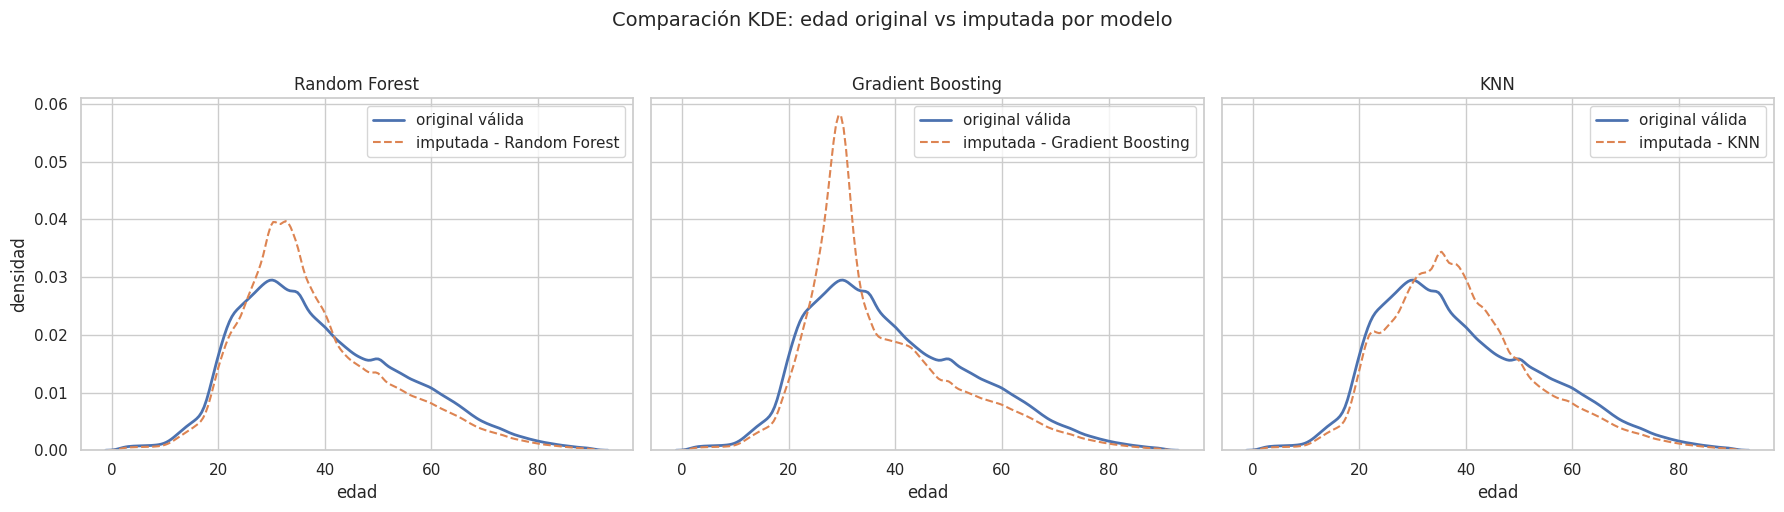

In [ ]:


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# ======================================================
# 0. NORMALIZAR NA Y TIPOS
# ======================================================

df = df.replace({pd.NA: np.nan})

cols_cat = ["victima_sexo", "victima_descendencia", "categoria_delito"]
cols_num = ["hora_ocurrencia", "area_codigo"]

df[cols_cat] = df[cols_cat].astype("object")
for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors="coerce")


# ======================================================
# 1. LIMPIEZA DE EDAD
# ======================================================

df["vict_age_original"] = pd.to_numeric(df["victima_edad"], errors="coerce")
df["vict_age_clean"] = df["vict_age_original"].copy()

mask_invalid_age = (
    (df["vict_age_clean"] <= 0) |
    (df["vict_age_clean"] > 90) |
    df["vict_age_clean"].isna()
)

df.loc[mask_invalid_age, "vict_age_clean"] = np.nan
print("Registros inválidos a imputar:", mask_invalid_age.sum())


# ======================================================
# 2. FEATURES Y DATAFRAME PARA MODELAR
# ======================================================

features = [
    "victima_sexo",
    "victima_descendencia",
    "categoria_delito",
    "hora_ocurrencia",
    "area_codigo"
]

df_model = df[features + ["vict_age_clean"]].copy()
df_model = df_model.replace({pd.NA: np.nan})

df_train = df_model[df_model["vict_age_clean"].notna()].copy()
df_missing = df_model[df_model["vict_age_clean"].isna()].copy()

print("Train:", df_train.shape)
print("Missing:", df_missing.shape)


# ======================================================
# 3. MUESTRA REPRESENTATIVA DE 100.000
# ======================================================

n_muestra = min(100000, df_train.shape[0])
df_train_sample = df_train.sample(n=n_muestra, random_state=42)

X_train = df_train_sample[features].copy()
y_train = df_train_sample["vict_age_clean"].copy()

X_missing = df_missing[features].copy()


# ======================================================
# 4. PREPROCESAMIENTO COMÚN
# ======================================================

preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore"))
    ]), cols_cat),

    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median"))
    ]), cols_num)
])


# ======================================================
# 5. DEFINIR MODELOS Y PIPELINES
# ======================================================

modelos = {
    "rf": RandomForestRegressor(
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    ),
    "gb": GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    "knn": KNeighborsRegressor(n_neighbors=7)
}

etiquetas_modelos = {
    "rf": "Random Forest",
    "gb": "Gradient Boosting",
    "knn": "KNN"
}

pipelines = {
    nombre: Pipeline([
        ("prep", preprocess),
        ("reg", modelo)
    ])
    for nombre, modelo in modelos.items()
}


# ======================================================
# 6. EVALUACIÓN: MAE PARA CADA MODELO (3-fold CV)
# ======================================================

mae_resultados = {}

print("\n===== Evaluación MAE (validación cruzada 3-fold) =====")

for nombre, pipe in pipelines.items():
    print(f"\nEvaluando modelo: {etiquetas_modelos[nombre]} ...")

    mae_scores = -cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=3,
        n_jobs=-1
    )

    mae_mean = mae_scores.mean()
    mae_std  = mae_scores.std()

    mae_resultados[nombre] = (mae_mean, mae_std)

    print(f"MAE promedio: {mae_mean:.3f}")
    print(f"Desviación est.: {mae_std:.3f}")

print("\n===== MAE Final por modelo =====")
for nombre, (mae, sd) in mae_resultados.items():
    print(f"{etiquetas_modelos[nombre]:<20}  MAE = {mae:.3f}  (SD = {sd:.3f})")


# ======================================================
# 7. ENTRENAR CADA MODELO EN TODA LA MUESTRA E IMPUTAR
# ======================================================

for nombre, pipe in pipelines.items():
    print(f"\nEntrenando modelo completo: {etiquetas_modelos[nombre]}")
    pipe.fit(X_train, y_train)

    X_missing_safe = X_missing.replace({pd.NA: np.nan})
    preds = pipe.predict(X_missing_safe)

    col_imp = f"vict_age_imp_{nombre}"
    df[col_imp] = df["vict_age_clean"].copy()
    df.loc[df_missing.index, col_imp] = preds

print("\nImputación completada para rf, gb y knn.")


# ======================================================
# 8. SUBPLOTS KDE COMPARATIVOS
# ======================================================

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)

edad_original_valida = df.loc[~mask_invalid_age, "vict_age_original"]

for ax, nombre in zip(axes, ["rf", "gb", "knn"]):
    col_imp = f"vict_age_imp_{nombre}"

    sns.kdeplot(
        edad_original_valida,
        label="original válida",
        linewidth=2,
        ax=ax
    )

    sns.kdeplot(
        df[col_imp],
        label=f"imputada - {etiquetas_modelos[nombre]}",
        linestyle="--",
        ax=ax
    )

    ax.set_title(etiquetas_modelos[nombre])
    ax.set_xlabel("edad")
    ax.set_ylabel("densidad")
    ax.legend()

plt.suptitle("Comparación KDE: edad original vs imputada por modelo", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
df = df_copy

Registros inválidos: 270134
Mediana usada: 37.0


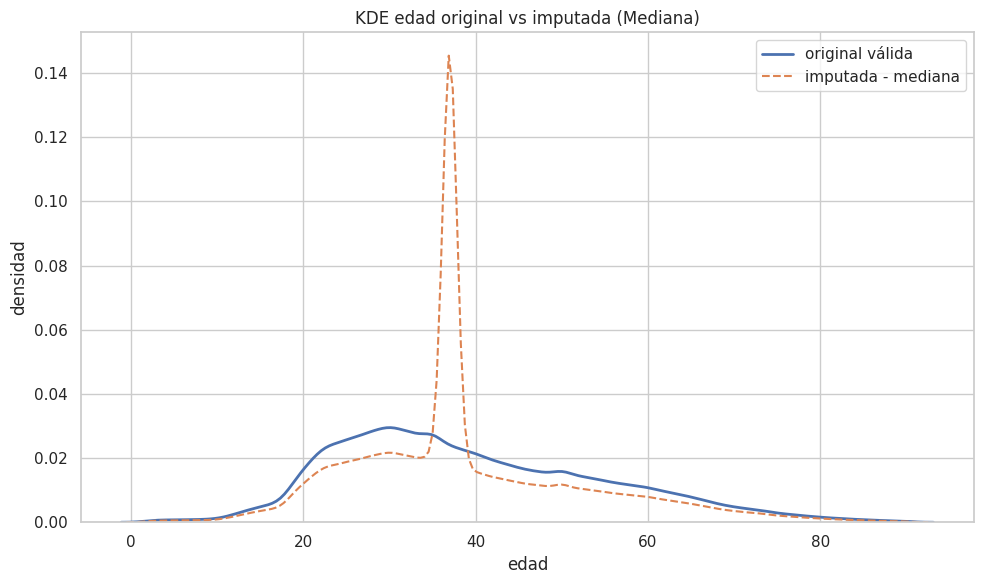

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ======================================================
# 1. LIMPIAR LA EDAD COMO SIEMPRE
# ======================================================

df["vict_age_original"] = pd.to_numeric(df["victima_edad"], errors="coerce")
df["vict_age_clean"] = df["vict_age_original"].copy()

mask_invalid_age = (
    (df["vict_age_clean"] <= 0) |
    (df["vict_age_clean"] > 90) |
    df["vict_age_clean"].isna()
)

df.loc[mask_invalid_age, "vict_age_clean"] = np.nan
print("Registros inválidos:", mask_invalid_age.sum())


# ======================================================
# 2. IMPUTACIÓN POR MEDIANA
# ======================================================

mediana_edad = df["vict_age_clean"].median()
print("Mediana usada:", mediana_edad)

df["vict_age_imp_mediana"] = df["vict_age_clean"].copy()
df.loc[df["vict_age_imp_mediana"].isna(), "vict_age_imp_mediana"] = mediana_edad


# ======================================================
# 3. KDE COMPARATIVO
# ======================================================

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# original válida
sns.kdeplot(
    df.loc[~mask_invalid_age, "vict_age_original"],
    label="original válida",
    linewidth=2
)

# imputación por mediana
sns.kdeplot(
    df["vict_age_imp_mediana"],
    label="imputada - mediana",
    linestyle="--"
)

plt.title("KDE edad original vs imputada (Mediana)")
plt.xlabel("edad")
plt.ylabel("densidad")
plt.legend()
plt.tight_layout()
plt.show()
